# Reconocimiento de Imágenes en CIFAR10

Para experimentar con el reconocimiento de imagenes y la clasificacion se estudia el dataset *CIFAR10*, el cual contiene 60.000 imagenes de 32 $\times$ 32 con las diez clases: gato, perro, rana, caballo, pájaro, ciervo, avión, automóvil, camión y barco.
Los datos vienen separados en datos de entrenamiento y de pruebas, para un estudio eficiente con las tecnicas como *redes neuronales*, *arboles*, *SVM* entre otras.

[[ 59  43  50 ..., 140  84  72]
 [154 126 105 ..., 139 142 144]
 [255 253 253 ...,  83  83  84]
 ..., 
 [ 71  60  74 ...,  68  69  68]
 [250 254 211 ..., 215 255 254]
 [ 62  61  60 ..., 130 130 131]]


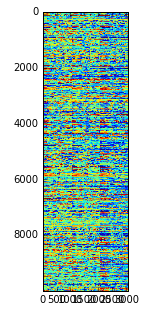

In [1]:
def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

dict1 = unpickle("datasets/data_batch_1")
X = dict1["data"]
print X

label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.imshow(X)
plt.show()

## A)

In [2]:
from scipy.misc import imread
import cPickle as pickle
import numpy as np
import os

def load_CIFAR_one(filename):
    with open(filename, "rb") as f:
        datadict = pickle.load(f)
        X = datadict["data"]
        Y = datadict["labels"]
        return X, np.array(Y)

def load_CIFAR10(PATH):
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(PATH, "data_batch_%d" % (b, ))
        X, Y = load_CIFAR_one(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    
    Xte, Yte = load_CIFAR_one(os.path.join(PATH, "test_batch"))
    
    #adding Xval
    index = np.arange(np.shape(Xtr)[0]) #filas 
    np.random.shuffle(index) #permutan las filas
    X = Xtr[index, :] #matriz permutada
    Y = Ytr[index]

    #l =  np.random.randint(1000,10000) #entrego 7433
    n = Xtr.shape[0]
    l = 7433
    
    Xval,Xtr = np.split(X,[l])
    Yval,Ytr = np.split(Y,[l])
    
    return Xtr, Ytr, Xte, Yte,Xval,Yval

X_train,Y_train, X_test,Y_test, X_val,Y_val = load_CIFAR10('datasets/')

print X_train
print 'Training set shape: ',X_train.shape
print 'Validation set shape: ',X_val.shape
print 'Test set shape: ',X_test.shape 

[[152 152 148 ..., 136 130 128]
 [ 42  40  25 ..., 137 153 127]
 [155 151 155 ...,  91  76  74]
 ..., 
 [151 161 171 ..., 144 138 132]
 [ 22  24  41 ..., 142 147 139]
 [255 255 255 ..., 156 167 170]]
Training set shape:  (42567, 3072)
Validation set shape:  (7433, 3072)
Test set shape:  (10000, 3072)


En primer lugar, se construye una funcion que carga los bloques de entrenamiento, de pruebas y de validacion del dataset en las matrices $X_{train}$, $Y_{train}$, $X_{test}$, $Y_{test}$ y $X_{val}$, $Y_{val}$ respectivamente. Las filas de estas matrices representan cada imagen del dataset, siendo los valores de la fila valores enteros de 0 a 255, que representan los valores de los colores que vienen por los canales *R*,*G* y *B*.

Se puede observar que la matriz $X_{train}$ posee 42567 filas, es decir, 42567 imagenes de entrenamiento. Por otro lado $X_{val}$ posee 7433 imagenes de validacion y $X_{test}$ 10000 imagenes de prueba.

In [34]:
print Y_train
print Y_val

[8 4 3 ..., 9 8 1]
[7 8 6 ..., 4 9 5]


## B)

In [3]:
# Escalar y centrar datos
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier as Tree
from keras.utils.np_utils import to_categorical

def scaler_t(X,Xv,Xt,scaler_type):
    if scaler_type == "standar":
        scaler= StandardScaler(with_std=True).fit(X)
        return scaler.transform(X), scaler.transform(Xv), scaler.transform(Xt)
    elif scaler_type == "int_max":
        aux = [ X/255.0, Xv/255.0, Xt/255.0 ]
        newX = aux[0].copy()
        newXv = aux[1].copy()
        newXt = aux[2].copy()
        #newX[ newX <0.2] = 1
        #newX[ newX > 0.8] = 0
        #newXv[ newXv <0.2] = 1
        #newXv[ newXv > 0.8] = 0
        #newXt[ newXt <0.2] = 1
        #newXt[ newXt > 0.8] = 0
        return newX,newXv,newXt
    elif scaler_type == "zeros_ones":
        newX = X.copy()
        newXv = Xv.copy()
        newXt = Xt.copy()
        newX[ newX <128] = 0
        newX[ newX > 127] = 1
        newXv[ newXv <128] = 0
        newXv[ newXv > 127] = 1
        newXt[ newXt < 128] = 0
        newXt[ newXt > 127] = 1
        return newX,newXv,newXt
    else: #otro
        return X*0.5

X,Xv,Xt = scaler_t(X_train,X_val,X_test,"standar")
print X

X,Xv,Xt = scaler_t(X_train,X_val,X_test,"int_max")
print X

X,Xv,Xt = scaler_t(X_train,X_val,X_test,"zeros_ones")
print X

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


[[-0.22652595 -0.23547842 -0.23478773 ..., -1.35456215 -1.2726719
  -1.23281747]
 [ 0.52309228  0.52469012  0.51379339 ..., -0.67515192 -0.62735892
  -0.67207938]
 [ 0.60486881  0.4279414   0.80490827 ...,  1.5946959   1.53904893
   1.54056283]
 ..., 
 [-1.18058552 -1.18914442 -1.20517067 ..., -1.53985585 -1.53387001
  -1.50560898]
 [-1.38502685 -1.35499937 -0.90019317 ...,  0.08146402  0.01795406
  -0.1871167 ]
 [ 0.11420961  0.19298021  0.25040373 ..., -0.16559425 -0.1049627
  -0.1871167 ]]
[[ 0.44705882  0.44313725  0.44705882 ...,  0.10196078  0.12156863
   0.12941176]
 [ 0.6627451   0.65882353  0.65882353 ...,  0.2745098   0.28627451
   0.2745098 ]
 [ 0.68627451  0.63137255  0.74117647 ...,  0.85098039  0.83921569
   0.84705882]
 ..., 
 [ 0.17254902  0.17254902  0.17254902 ...,  0.05490196  0.05490196
   0.05882353]
 [ 0.11372549  0.1254902   0.25882353 ...,  0.46666667  0.45098039  0.4       ]
 [ 0.54509804  0.56470588  0.58431373 ...,  0.40392157  0.41960784  0.4       ]]
[[0 0 

En esta seccion se escalan las imagenes, para poder trabajarlas de forma apropiada. Este escalamiento se realiza en base a la intensidad maxima de los pixeles de las imagenes y se procede a centrar y estandarizar normalmente.

## C) ANN - analisis

In [27]:
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from keras.optimizers import SGD,RMSprop


Xtr,Xv,Xt = scaler_t(X_train,X_val,X_test,"standar")
Ytr = to_categorical(Y_train)
Yv = to_categorical(Y_val)
Yt = to_categorical(Y_test)
print "Para representacion datos normalizados estandar"

#experimentar variando valores
model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.05), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=32, verbose=0, validation_data=(Xv,Yv))

scores = model.evaluate(Xv, Yv)

print "VALIDATION ACCURACY (activation relu-softmax) = %f"% scores[1]

model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='sigmoid'))
model.compile(optimizer=SGD(lr=0.05), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=32, verbose=0, validation_data=(Xv,Yv))

scores = model.evaluate(Xv, Yv)

print "VALIDATION ACCURACY (activation relu-sigmoid) = %f"% scores[1]

model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='sigmoid'))
model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=32, verbose=0, validation_data=(Xv,Yv))

scores = model.evaluate(Xv, Yv)

print "VALIDATION ACCURACY (optimizer RMSprop and activation relu-sigmoid) = %f"% scores[1]

print "------------------------------------------------"

X,Xv,Xt = scaler_t(X_train,X_val,X_test,"int_max")
Ytr = to_categorical(Y_train)
Yv = to_categorical(Y_val)
Yt = to_categorical(Y_test)
print "Para representacion datos escalados por la intensidad maxima (0-255 pasa a 0-1)"

#experimentar variando valores
model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.05), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=32, verbose=0, validation_data=(Xv,Yv))

scores = model.evaluate(Xv, Yv)
print "VALIDATION ACCURACY (activation relu-softmax) = %f"% scores[1]

#experimentar variando valores
model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='sigmoid'))
model.compile(optimizer=SGD(lr=0.05), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=32, verbose=0, validation_data=(Xv,Yv))

scores = model.evaluate(Xv, Yv)
print "VALIDATION ACCURACY (activation relu-sigmoid)= %f"% scores[1]


Para representacion datos normalizados estandar
7328/7433 [============================>.] - ETA: 0sVALIDATION ACCURACY (optimizer RMSprop and activation relu-sigmoid) = 0.908973
------------------------------------------------
Para representacion datos escalados por la intensidad maxima (0-255 pasa a 0-1)
7360/7433 [============================>.] - ETA: 0sVALIDATION ACCURACY (activation relu-sigmoid)= 0.887502


In [7]:
#scores = model.evaluate(Xt, Yt)
#print "TEST ACCURACY = %f"% scores[1]
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from keras.optimizers import SGD,RMSprop

#Xtr,Xv,Xt = scaler_t(X_train,X_val,X_test,"standar")
Ytr = to_categorical(Y_train)
Yv = to_categorical(Y_val)
Yt = to_categorical(Y_test)
#X,Xv,Xt = scaler_t(X_train,X_val,X_test,"int_max")
Xtr,Xv,Xt = X_train,X_val,X_test
model = Sequential()
model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, init='uniform', activation='softmax'))
model.compile(optimizer=SGD(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(Xtr, Ytr, nb_epoch=50, batch_size=32, verbose=0, validation_data=(Xv,Yv))
scores = model.evaluate(Xv, Yv)
print "VALIDATION ACCURACY (activation relu-softmax) = %f"% scores[1]

Train on 42567 samples, validate on 7433 samples
Epoch 1/50
42567/42567 [==============================] - 10s - loss: 0.3161 - acc: 0.9000 - val_loss: 0.3053 - val_acc: 0.9000
Epoch 2/50
42567/42567 [==============================] - 9s - loss: 0.2987 - acc: 0.9000 - val_loss: 0.2928 - val_acc: 0.9001
Epoch 3/50
42567/42567 [==============================] - 10s - loss: 0.2894 - acc: 0.9006 - val_loss: 0.2857 - val_acc: 0.9008
Epoch 4/50
42567/42567 [==============================] - 9s - loss: 0.2838 - acc: 0.9007 - val_loss: 0.2813 - val_acc: 0.9010
Epoch 5/50
42567/42567 [==============================] - 10s - loss: 0.2794 - acc: 0.9014 - val_loss: 0.2779 - val_acc: 0.9014
Epoch 6/50
42567/42567 [==============================] - 9s - loss: 0.2765 - acc: 0.9018 - val_loss: 0.2754 - val_acc: 0.9022
Epoch 7/50
42567/42567 [==============================] - 10s - loss: 0.2741 - acc: 0.9022 - val_loss: 0.2734 - val_acc: 0.9023
Epoch 8/50
42567/42567 [==============================] - 

## D)

In [9]:
from top_level_features import hog_features
from top_level_features import color_histogram_hsv
from top_level_features import extract_features
X_train, Y_train, X_test, Y_test,X_val,Y_val = load_CIFAR10("datasets/")
print X_train.shape

features = extract_features(X_train,[hog_features],verbose=0) #extrae hog features
print 'Dimensiones de representacion segun histograma de gradientes: ',features.shape
features = extract_features(X_train,[color_histogram_hsv]) #extrae histogramas de color
print 'Dimensiones de representacion segun histogramas de color: ',features.shape
features = extract_features(X_train,[hog_features, color_histogram_hsv]) #extrae todo
print 'Dimensiones de representacion mixta: ' ,features.shape

print features

(42567, 3072)
(42567, 32, 32, 3)
Dimensiones de representacion segun histograma de gradientes:  (42567, 144)
(42567, 32, 32, 3)
Dimensiones de representacion segun histogramas de color:  (42567, 10)
(42567, 32, 32, 3)
Dimensiones de representacion mixta:  (42567, 154)
[[  3.28252652e+00   9.02344707e-01   0.00000000e+00 ...,   1.46484375e-02
    1.46484375e-02   4.49218750e-02]
 [  1.27768186e+00   2.71226101e+00   6.44353672e-01 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.93778528e+00   0.00000000e+00   8.79941741e-01 ...,   9.57031250e-02
    4.49218750e-02   7.32421875e-02]
 ..., 
 [  1.02592044e+00   5.98453495e-01   5.65761366e-01 ...,   1.46484375e-02
    1.26953125e-02   1.75781250e-02]
 [  4.52694478e-01   9.61371393e-01   1.09370906e+00 ...,   6.83593750e-03
    6.83593750e-03   1.75781250e-02]
 [  0.00000000e+00   0.00000000e+00   5.84914941e-02 ...,   1.95312500e-03
    1.95312500e-03   2.63671875e-02]]


In [10]:
def representacion(x,xv,xt,tipo):
    if tipo=="hog":
        features_train = extract_features(x,[hog_features]) #extrae hog features
        features_val = extract_features(xv,[hog_features]) #extrae hog features
        features_test = extract_features(xt,[hog_features]) #extrae hog features
    elif tipo=="histogram":
        features_train = extract_features(x,[color_histogram_hsv]) #extrae histogramas de color
        features_val = extract_features(xv,[color_histogram_hsv]) #extrae histogramas de color
        features_test = extract_features(xt,[color_histogram_hsv]) #extraehistogramas de color
    else:
        features_train = extract_features(x,[hog_features, color_histogram_hsv]) #extrae todo
        features_val = extract_features(xv,[hog_features, color_histogram_hsv]) #extrae todo
        features_test = extract_features(xt,[hog_features, color_histogram_hsv]) #extrae todo

    return features_train,features_val,features_test

## E) SVM no lineal

In [63]:
#ajustar SVM no lineal sobre las distintas representaciones y variar hiperparametros
from sklearn.svm import SVC
from keras.utils.np_utils import to_categorical


Cs = [pow(2,k) for k in np.arange(-2,7,1)]
def do_SVC(x,y,xv,yv):
    mejor = 0
    info1 = []
    info2 = []
    for C in Cs:
        clf1 = SVC(C=C, kernel="rbf")
        clf2 = SVC(C=C, kernel="poly",degree=2, coef0=1)
        
        clf1 = clf1.fit(x,y)
        clf2 = clf2.fit(x,y)
        
        acc_1 = clf1.score(x,y)
        accv_1 = clf1.score(xv,yv)
        
        acc_2 = clf2.score(x,y)
        accv_2 = clf2.score(xv,yv)
        
        if accv_1 > mejor:
            mejor = accv_1
        if accv_2 > mejor:
            mejor = accv_2
        info1.append([acc_1,accv_1])
        info2.append([acc_2,accv_2])
    print "Best Validation Accuracy = %f"%mejor
    return info1,info2

In [ ]:
Xtr,Xv,Xt = scaler_t(X_train,X_val,X_test,"standar")
print X.shape

clf = SVC(C=1, kernel="rbf",verbose=1)        
clf = clf.fit(Xtr,Y_train)  

acc = clf.score(Xt,Y_test)
print "TEST ACCURACY WITH STANDAR NORMALIZE = %f"% acc

#do_SVC(X,Ytr,Xv,Yv)

(42567, 3072)
(42567, 10)
[LibSVM]

In [ ]:
#probar otros

In [ ]:
Xtr,Xv,Xt = representacion(X_train,X_val,X_test,"hog")

clf = SVC(C=1, kernel="rbf",verbose=1)        
clf = clf.fit(Xtr,Y_train)  

acc = clf.score(Xt,Y_test)
print "TEST ACCURACY WITH STANDAR NORMALIZE = %f"% acc

## F) Árbol de Clasificación

In [46]:
from sklearn.tree import DecisionTreeClassifier as Tree
from keras.utils.np_utils import to_categorical

N_ts = [2,5,10,13,17,20,25,30,50,80,90,100,150]
def do_Tree(x,y,xv,yv):
    mejor = 0
    nivel = 0
    info = []
    for n_t in N_ts:
        print "arbol: %d"%n_t
        clf=Tree(criterion="gini",splitter="best",random_state=0,max_depth=n_t)
        clf.fit(x,y)
        acc = clf.score(x,y)
        acc_v = clf.score(xv,yv)
        if acc_v > mejor:
            mejor = acc_v
            nivel = n_t
        info.append([acc,acc_v])
    print "Best Validation Accuracy = %f"%mejor
    print "Tree's Level = %f"%nivel
    return info

In [47]:
Xtr,Xv,Xt = scaler_t(X_train,X_val,X_test,"standar")

#cuidado---se demora harto
info1 = do_Tree(Xtr,Y_train,Xv,Y_val)

arbol: 2
arbol: 5
arbol: 10
arbol: 13
arbol: 17
arbol: 20
arbol: 25
arbol: 30
arbol: 50
arbol: 80
arbol: 90
arbol: 100
arbol: 150
Best Validation Accuracy = 0.267052
Tree's Level = 30.000000


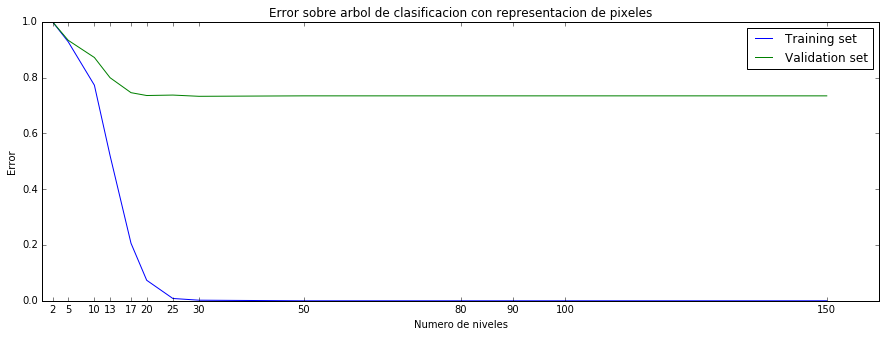

In [54]:
#utilizar el info
error1 = [1-i[0] for i in info1]
error2 = [1-i[1] for i in info1]
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(N_ts,error1, label = "Training set")
plt.plot(N_ts,error2, label = "Validation set")
plt.xticks(N_ts)
plt.xlabel('Numero de niveles')
plt.ylabel('Error')
plt.title('Error sobre arbol de clasificacion con representacion estandarizada de pixeles')
plt.legend(loc="upper right")
plt.show()

In [26]:
Xtr,Xv,Xt = scaler_t(X_train,X_val,X_test,"int_max")

clf=Tree(criterion="gini",splitter="best",random_state=0,max_depth=10)
clf.fit(Xtr,Y_train)
acc = clf.score(Xv,Y_val)
print "VALIDATION ACCURACY WITH NORMALIZE BETWEEN 0-1 = %f"% acc
        
#info2 = do_Tree(Xtr,Ytr,Xv,Yv)

VALIDATION ACCURACY WITH NORMALIZE BETWEEN 0-1 = 0.292479


In [19]:
Xtr,Xv,Xt = scaler_t(X_train,X_val,X_test,"zeros_ones")

clf=Tree(criterion="gini",splitter="best",random_state=0,max_depth=10)
clf.fit(Xtr,Y_train)
acc = clf.score(Xv,Y_val)
print "VALIDATION ACCURACY WITH 0's and 1's REPRESENTATION = %f"% acc

#info3 = do_Tree(Xtr,Ytr,Xv,Yv)

VALIDATION ACCURACY WITH 0's and 1's REPRESENTATION = 0.284946


A continuación se prueban las distintas representaciones de extracción de características

In [20]:
Xtr,Xv,Xt = representacion(X_train,X_val,X_test,"hog")

clf=Tree(criterion="gini",splitter="best",random_state=0,max_depth = 10)
clf.fit(Xtr,Y_train)
acc = clf.score(Xv,Y_val)
print "VALIDATION ACCURACY WITH HOG REPRESENTATION = %f"% acc

#info4 = do_Tree(Xtr,Ytr,Xv,Yv)

(42567, 32, 32, 3)
(7433, 32, 32, 3)
(10000, 32, 32, 3)
VALIDATION ACCURACY WITH HOG REPRESENTATION = 0.291941


In [21]:
Xtr,Xv,Xt = representacion(X_train,X_val,X_test,"histogram")

clf=Tree(criterion="gini",splitter="best",random_state=0,max_depth=10)
clf.fit(Xtr,Y_train)
acc = clf.score(Xv,Y_val)
print "VALIDATION ACCURACY WITH COLOR HISTOGRAM REPRESENTATION = %f"% acc

#info5 = do_Tree(Xtr,Ytr,Xv,Yv)

(42567, 32, 32, 3)
(7433, 32, 32, 3)
(10000, 32, 32, 3)
VALIDATION ACCURACY WITH COLOR HISTOGRAM REPRESENTATION = 0.262344


In [12]:
from sklearn.tree import DecisionTreeClassifier as Tree

Xtr,Xv,Xt = representacion(X_train,X_val,X_test,"combinacion")

clf=Tree(criterion="gini",splitter="best",random_state=0,max_depth=10)
clf.fit(Xtr,Y_train)
acc = clf.score(Xv,Y_val)
print "VALIDATION ACCURACY WITH COLOR HISTOGRAM AND HOG REPRESENTATION = %f"% acc

clf=Tree(criterion="gini",splitter="best",random_state=0,max_depth=30)
clf.fit(Xtr,Y_train)
acc = clf.score(Xv,Y_val)
print "VALIDATION ACCURACY WITH COLOR HISTOGRAM AND HOG REPRESENTATION = %f"% acc

clf=Tree(criterion="gini",splitter="best",random_state=0,max_depth=50)
clf.fit(Xtr,Y_train)
acc = clf.score(Xv,Y_val)
print "VALIDATION ACCURACY WITH COLOR HISTOGRAM AND HOG REPRESENTATION = %f"% acc

clf=Tree(criterion="gini",splitter="best",random_state=0,max_depth=100)
clf.fit(Xtr,Y_train)
acc = clf.score(Xv,Y_val)
print "VALIDATION ACCURACY WITH COLOR HISTOGRAM AND HOG REPRESENTATION = %f"% acc

(42567, 32, 32, 3)
(7433, 32, 32, 3)
(10000, 32, 32, 3)
VALIDATION ACCURACY WITH COLOR HISTOGRAM AND HOG REPRESENTATION = 0.315485
VALIDATION ACCURACY WITH COLOR HISTOGRAM AND HOG REPRESENTATION = 0.273241
VALIDATION ACCURACY WITH COLOR HISTOGRAM AND HOG REPRESENTATION = 0.273645
VALIDATION ACCURACY WITH COLOR HISTOGRAM AND HOG REPRESENTATION = 0.273645


En base a lo anteriormente experimentado se escogen los mejores parametros y representación para un arbol de clasificación para este problema de clasificación de imágenes. Mostrando a continuación el error sobre el test set.

In [23]:
#la mejor representacion = combinacion
#el mejor nivel = 30
Xtr,Xv,Xt = representacion(X_train,X_val,X_test,"combinacion")

clf=Tree(criterion="gini",splitter="best",random_state=0,max_depth=10)
clf.fit(Xtr,Y_train)

acc = clf.score(Xt,Y_test)
print "TEST ACCURACY WITH ... = %f"% acc

(42567, 32, 32, 3)
(7433, 32, 32, 3)
(10000, 32, 32, 3)
TEST ACCURACY WITH ... = 0.312300
